# VEHICLE IMAGE CLASSIFICATION
---
# 1. Business Understanding
---
### 1.1 Overview
In collaboration with Kenya Imports Authority (KIA), this project aims to streamline vehicle identification processes at ports of entry. The Kenya Imports Authority oversees the regulation and importation of vehicles into the country, ensuring compliance with national laws and regulations. A machine learning model capable of accurately classifying different types of vehicles (such as Auto Rickshaws, Bikes, Cars, Motorcycles, Planes, Ships and Trains) would enhance operational efficiency, reduce manual errors and improve regulatory compliance.

The goal of this project is to build a vehicle classification model that can automatically identify the type of vehicle from an image. This can be applied in real-time during inspections or integrated into existing digital systems for batch processing.

#### Metrics of Success:
* Accuracy: The percentage of correctly classified vehicle images.
* Precision: The ability of the model to correctly classify positive instances without mislabeling others.

### 1.2 Problem Statement
Manually inspecting and classifying vehicles entering Kenya’s ports is both time-consuming and prone to human error. With thousands of vehicles arriving at the borders daily, it is increasingly difficult to ensure that each one is correctly classified and documented. A machine learning solution is needed to automate this process, allowing for faster, more accurate classification of vehicles. This project seeks to address the challenge of automatically identifying vehicle types using image recognition techniques.

### 1.3 Objectives
* Develop a machine learning model that can classify vehicles into one of seven predefined categories: `Auto Rickshaws`, `Bikes`, `Cars`, `Motorcycles`, `Planes`, `Ships` and `Trains`.
* Achieve a high accuracy and precision for classifying images from the dataset.
* Evaluate the performance of the model using test data.
* Deploying the model using streamlit.
---

# 2. Data Understanding
---

### 2.1 Data Source and Access
The dataset used for this project is sourced from Kaggle and can be accessed [here](https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification).
It's expected to contain `5,600` images across seven categories, each stored in a subfolder within the Vehicles folder. To manage the large size of the dataset, it has been uploaded to AWS S3 for efficient storage and access. The categories include:

* Auto Rickshaws
* Bikes
* Cars
* Motorcycles
* Planes
* Ships
* Trains

Each category is expected to contain 800 images in `.jpg` and `.png` formats, including both uppercase and lowercase extensions (`.JPG`, `.PNG`).

### 2.2 Data Loading
We are going to load the data and store the image urls in a dataframe. This allows for efficient management and on-demand loading of images.

In [24]:
# Import necessary libraries

import boto3
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
import random

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Filter future warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# AWS S3 setup
s3_client = boto3.client('s3')
bucket_name = 'vehicle-image-classification'
folder_path = 'Vehicles/' 

# Initialize an empty list to store data
data = []

# Using pagination to retrieve all objects in the Vehicles folder
paginator = s3_client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix=folder_path)

# Iterating through each page of results
for page in pages:
    if 'Contents' in page:
        files = [obj['Key'] for obj in page['Contents'] if obj['Key'].endswith(('.jpg', '.png', '.PNG', '.JPG'))]
        
        for file in files:
            category = file.split('/')[1]
            data.append([file, category])

# Creating a DataFrame to store the image paths and labels
df = pd.DataFrame(data, columns=['File Path', 'Category'])
df

,File Path,Category
0,Vehicles/Auto Rickshaws/Auto Rickshaw (1).jpg,Auto Rickshaws
1,Vehicles/Auto Rickshaws/Auto Rickshaw (10).jpg,Auto Rickshaws
2,Vehicles/Auto Rickshaws/Auto Rickshaw (100).jpg,Auto Rickshaws
3,Vehicles/Auto Rickshaws/Auto Rickshaw (101).jpg,Auto Rickshaws
4,Vehicles/Auto Rickshaws/Auto Rickshaw (102).jpg,Auto Rickshaws
...,...,...
5582,Vehicles/Trains/Train (95).jpg,Trains
5583,Vehicles/Trains/Train (96).jpg,Trains
5584,Vehicles/Trains/Train (97).png,Trains
5585,Vehicles/Trains/Train (98).png,Trains


### 2.3 Class Distribution
To understand the class distribution, we are going to calculate the number of images per category to ensure the dataset is balanced across all classes. 

In [3]:
# Check class distribution
class_distribution = df['Category'].value_counts()
class_distribution

Category
Auto Rickshaws    800
Bikes             800
Motorcycles       800
Ships             800
Trains            800
Planes            797
Cars              790
Name: count, dtype: int64

#### Observation:
The dataset is mostly balanced across categories, but `Planes` and `Cars` have slightly fewer images than expected.

---
# 3. Data Preparation
---
In this step, we will clean and organize the data to make it suitable for analysis and modeling.
### 3.1 Checking for Missing Values
First, let's check if there are any missing values in the dataset. This is important because missing data can lead to errors during analysis or modeling.

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 File Path    0
Category     0
dtype: int64


#### Observation:
* The data has no missing values.

### 3.2 Data Type Verification
Next, we should verify the data types to ensure that they are appropriate for the analysis we plan to perform.

In [6]:
print("Data types:\n", df.dtypes)

Data types:
 File Path    object
Category     object
dtype: object


### 3.3 Duplicates Check
Check for any duplicate entries in the dataset that could skew our analysis.

In [7]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


---
# 4. Exploratory Data Analysis (EDA)
---
In this section, we'll explore the dataset to gain insights into its structure and content. The goal of EDA is to understand the data before modeling by visualizing it and checking for any potential issues, such as imbalances, outliers or errors.

### 4.1 Overview of Data
Summarize the dataset to get an understanding of its structure and key statistics.

In [9]:
# Display general info about the dataset
print("Dataset Info:")
display(df.info())

# Display basic statistics for numerical features
print("\nBasic Statistics:")
display(df.describe(include='all'))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5587 entries, 0 to 5586
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Path  5587 non-null   object
 1   Category   5587 non-null   object
dtypes: object(2)
memory usage: 87.4+ KB


None


Basic Statistics:


,File Path,Category
count,5587,5587
unique,5587,7
top,Vehicles/Auto Rickshaws/Auto Rickshaw (1).jpg,Auto Rickshaws
freq,1,800


### 4.2 Visualizing Class Distribution
Visualizing the distribution of images across categories to check for class balance:

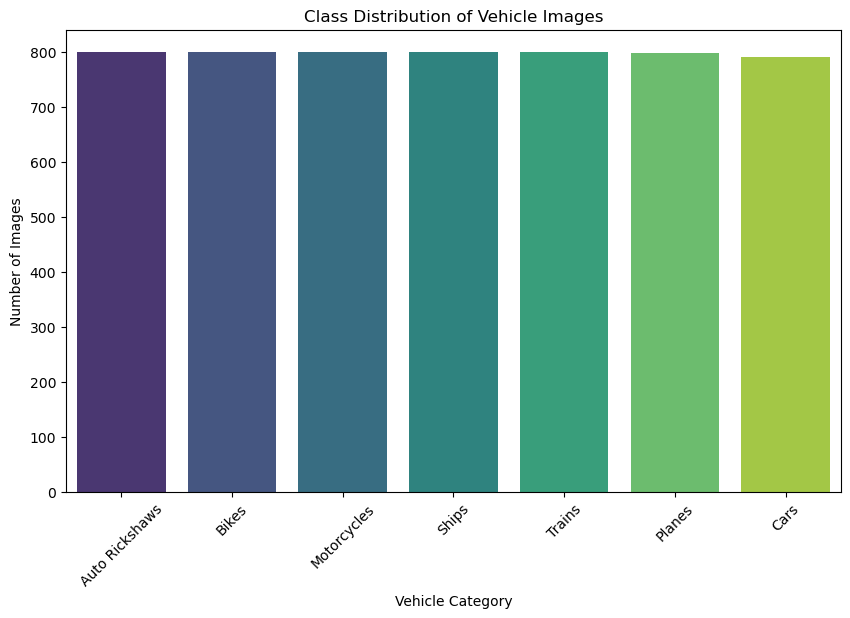

In [11]:
# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title("Class Distribution of Vehicle Images")
plt.xlabel("Vehicle Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

### 4.3 Sample Images from Each Category
Inspecting sample images from each category to verify labeling and visual variety:

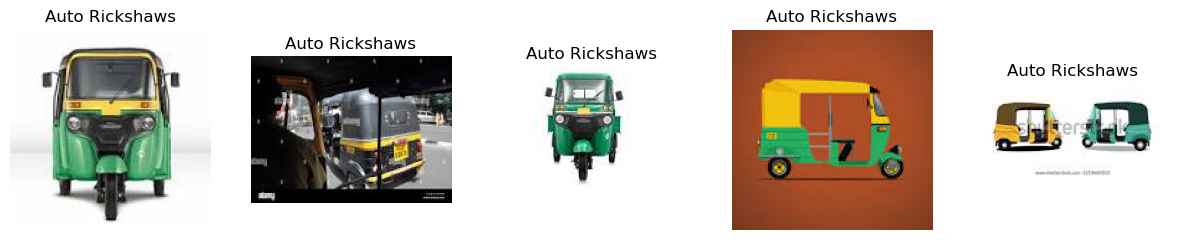

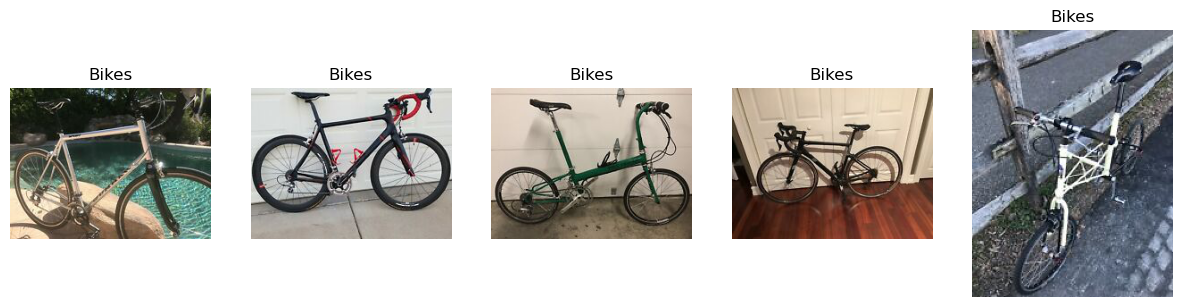

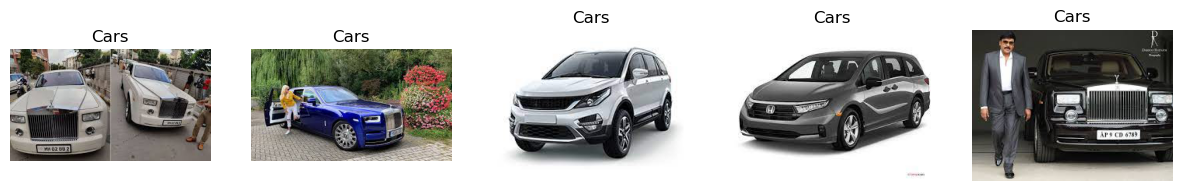

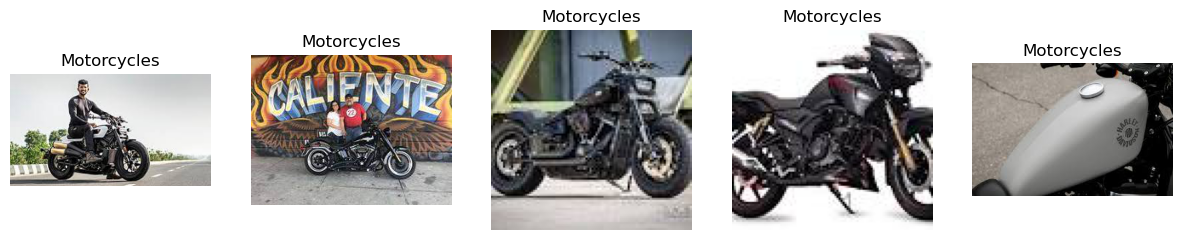

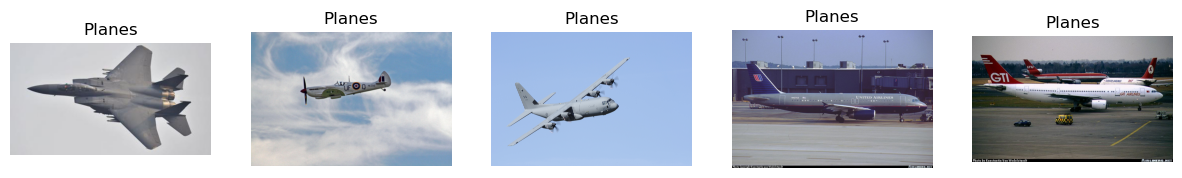

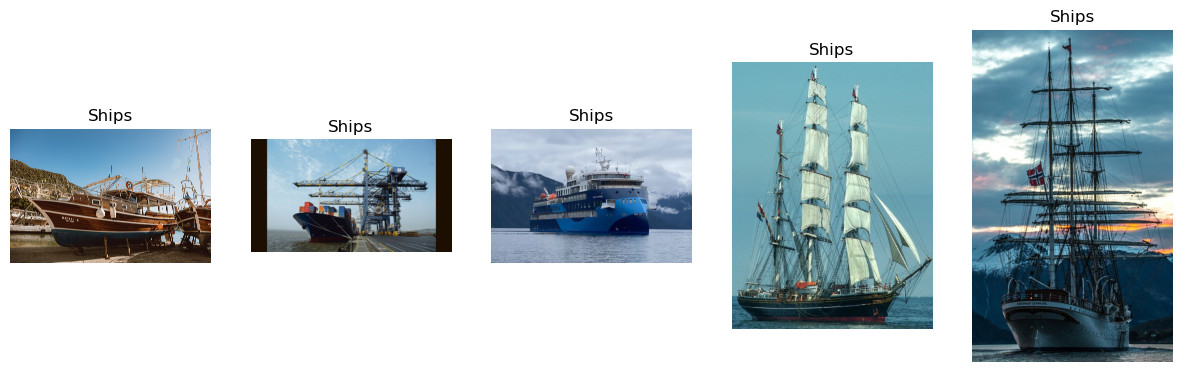

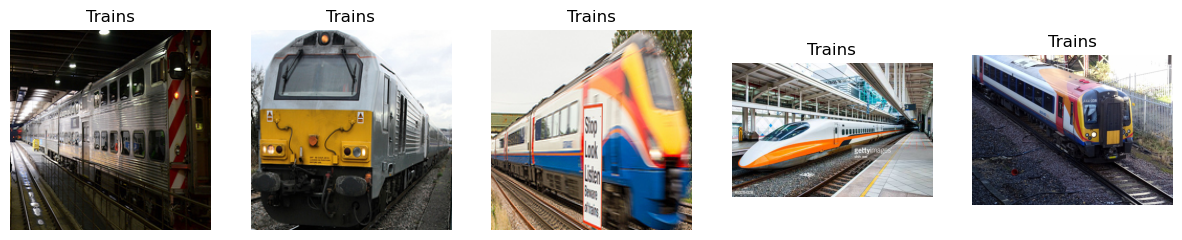

In [13]:
# Function to display sample images
def display_sample_images(df, category, num_samples=5):
    sample_images = df[df['Category'] == category].sample(num_samples)
    
    plt.figure(figsize=(15, 5))
    for i, row in enumerate(sample_images.iterrows()):
        img_path = row[1]['File Path']
        response = s3_client.get_object(Bucket=bucket_name, Key=img_path)
        img_data = response['Body'].read()
        img = Image.open(BytesIO(img_data))
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"{category}")
        plt.axis('off')
    plt.show()

# Display sample images for each category
for category in df['Category'].unique():
    display_sample_images(df, category)


### 4.4 Image Size and Aspect Ratio Analysis
Analyzing image sizes and aspect ratios to prepare for resizing or other preprocessing:

In [17]:
# Reduce the number of images to process by sampling to reduce processing time.
sample_size = 1000  
sampled_df = df.sample(n=sample_size, random_state=42)

image_sizes = []
aspect_ratios = []

for index, row in sampled_df.iterrows():
    img_path = row['File Path']
    response = s3_client.get_object(Bucket=bucket_name, Key=img_path)
    img_data = response['Body'].read()
    img = Image.open(BytesIO(img_data))
    
    width, height = img.size
    image_sizes.append((width, height))
    aspect_ratios.append(width / height)

# Convert to DataFrame for easy analysis
size_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
aspect_ratio_df = pd.DataFrame(aspect_ratios, columns=['Aspect Ratio'])

# Summary statistics
print(size_df.describe())
print(aspect_ratio_df.describe())


             Width       Height
count  1000.000000  1000.000000
mean    624.037000   426.550000
std     765.483618   522.994743
min      63.000000    59.000000
25%     193.500000   167.750000
50%     275.000000   192.000000
75%     802.500000   520.500000
max    5184.000000  4613.000000
       Aspect Ratio
count   1000.000000
mean       1.452640
std        0.380435
min        0.399771
25%        1.256691
50%        1.500000
75%        1.679849
max        3.981061


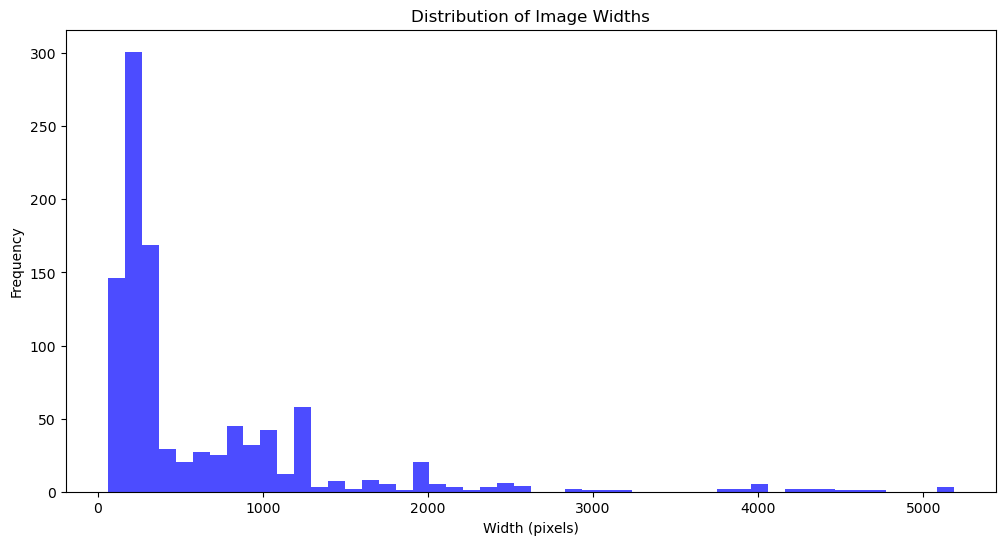

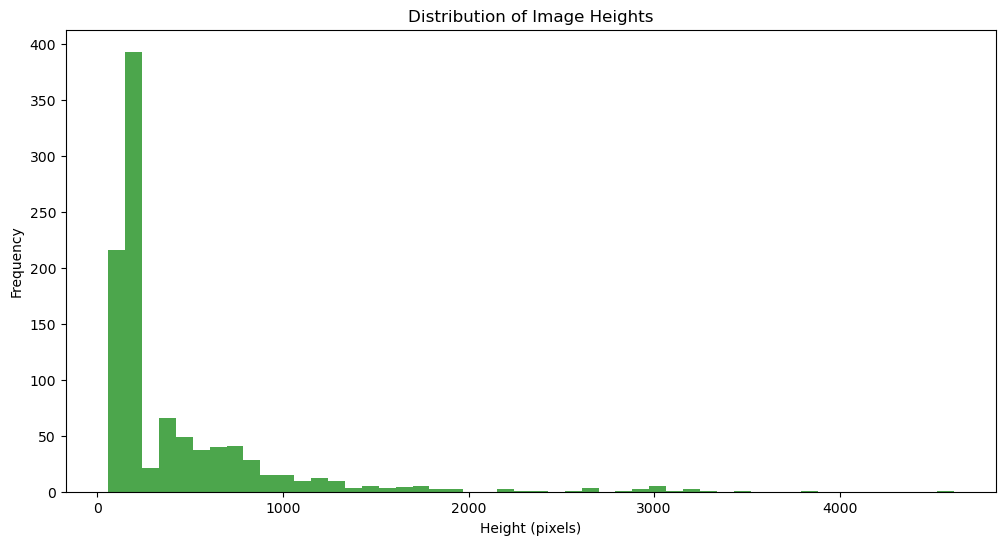

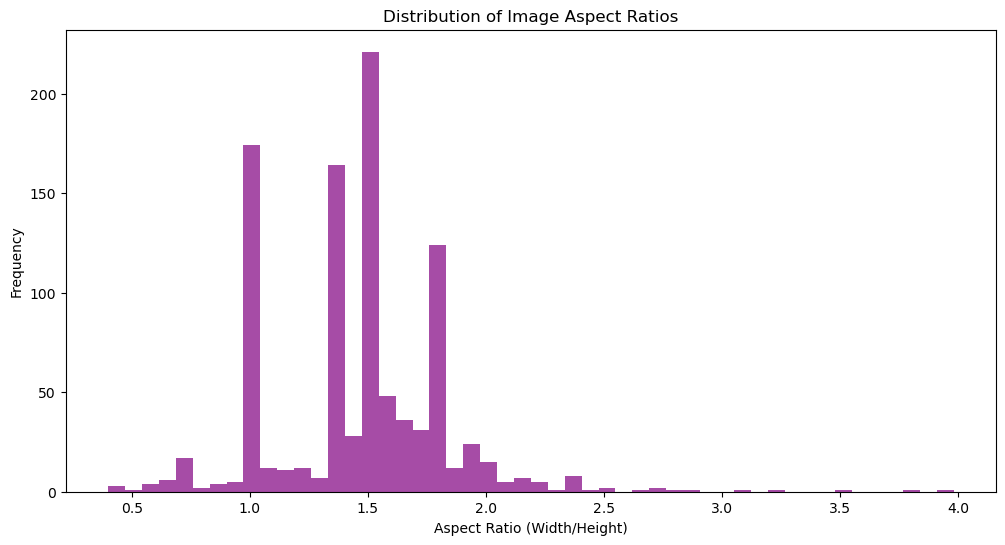

In [19]:
# Plotting the distribution of image widths
plt.figure(figsize=(12, 6))
plt.hist(size_df['Width'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of image heights
plt.figure(figsize=(12, 6))
plt.hist(size_df['Height'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of aspect ratios
plt.figure(figsize=(12, 6))
plt.hist(aspect_ratio_df['Aspect Ratio'], bins=50, color='purple', alpha=0.7)
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.show()


#### Observations:
* The images have different sizes of width and height.
* Most image width and height range from around 10 to 1000 pixels.
* Distribution of image aspect ratio is a normal distribution.
---
# 5. Data Preprocessing
---
Here we'll handle the necessary preprocessing to prepare the dataset for modeling.

### 5.1 Label Encoding
Convert the categorical labels into numerical format using label encoding.

In [28]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Category' column
df['Category_Encoded'] = label_encoder.fit_transform(df['Category'])

# Check the encoded categories
df['Category_Encoded'].value_counts()

Category_Encoded
0    800
1    800
3    800
5    800
6    800
4    797
2    790
Name: count, dtype: int64

### 5.2 Normalization of image data

In [29]:
# Set up ImageDataGenerator for normalization
datagen = ImageDataGenerator(rescale=1.0/255.0)

### 5.3 Train-Test split
We'll split the data into training `80%` and testing `20%` sets, ensuring that the split is stratified to maintain the class distribution.

In [30]:
# Split the dataset into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Category_Encoded'])

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")


Training set: 4469 samples
Test set: 1118 samples


# Modelling